### Try TemporalFusionTransformer
* Read: https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594

In [3]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer

import warnings
warnings.filterwarnings('ignore')

# Used Yujie's cleaned version
DIR_BYID = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/local_data/content/databyid'

ls_all_invest_ids = sorted([int(fn.split('.')[0]) for fn in os.listdir(os.path.join(DIR_BYID, 'target'))])

In [9]:
f_cols = [f"f_{i}" for i in range(300)]
# Read a subset for testing
n = 3
ls_dfs = []
for id in ls_all_invest_ids[:n]:
    df_f_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'feats/{id}.npy')), columns=f_cols)
    df_t_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'target/{id}.npy')), columns=['target'])
    df_f_id['investment_id'] = id
    ls_dfs.append(pd.concat([df_t_id, df_f_id], axis=1))

df = pd.concat(ls_dfs).reset_index().rename(columns={'index': 'time_id'})
df = df.sort_values(by=['time_id']) # sort by time before splitting
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
# df_train, df_val = train_test_split(df_train, test_size=2/9, shuffle=False)

In [5]:
df_train

,time_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,investment_id
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1220,0,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,...,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566,1
2440,0,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,...,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624,2
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1221,1,-0.917045,0.373575,0.296349,0.019102,-0.031842,-0.222027,-0.199950,1.325165,1.267433,...,-1.081652,0.645607,0.581035,0.839101,-0.362388,1.229239,-1.301037,-0.391490,0.330331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,852,-0.103114,0.023042,-1.143757,0.051038,-0.425743,0.116079,-2.102412,-1.080850,-0.465172,...,1.067677,-0.572875,1.130094,1.168141,-0.295463,-1.641248,0.754601,2.436651,0.609978,0
3292,852,-0.506390,-0.095416,-0.082392,0.628147,-0.495957,-0.217843,-0.729260,-0.055025,1.161049,...,0.259313,-0.095036,0.595668,1.450615,-0.901555,-0.468974,0.767649,-0.507186,-0.582950,2
3293,853,-1.222850,0.406415,0.427107,0.388093,-0.631475,-0.223392,-0.995415,0.352018,1.150299,...,-0.402418,-0.084839,1.354303,-1.412276,-0.598099,-2.042076,0.363272,-0.971272,-0.720224,2
2073,853,0.000000,0.125338,-0.784968,-0.026920,-0.332789,0.159759,-1.738487,-0.933227,-0.409914,...,-0.441070,-1.074331,-1.709144,0.333215,0.256185,-1.451273,1.051513,1.932738,0.274242,1


### Create dataset and dataloaders

In [7]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# load data
# define dataset
max_encoder_length = 6
max_prediction_length = 1

# create validation and training dataset
batch_size = 128
max_prediction_length = 3
max_encoder_length = 24

# create the dataset from the pandas dataframe
train_dataset = TimeSeriesDataSet(
    df_train,
    group_ids=["investment_id"],
    target="target",
    time_idx="time_id",
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_reals=[],
    time_varying_unknown_reals=['target'] + [f"f_{i}" for i in range(300)],
    target_normalizer=GroupNormalizer(
        groups=["investment_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, df_train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


### Find optimal learning rate

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 226.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Finding best initial lr: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


suggested learning rate: 0.2454708915685031


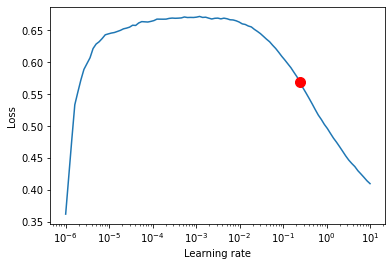

In [8]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")


# find optimal learning rate
res = trainer.tuner.lr_find(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train Model

* Note: use tensorboard to check the logs: run ```tensorboard --logdir=<logging_folder>```
* To visualize tensorboard in Jupyter Notebook: 
    ```
    %reload_ext tensorboard
    %tensorboard --logdir=<logging_folder>
    ```

In [15]:
from pytorch_lightning.loggers import WandbLogger
DIR_LOGS = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs' # Change this!
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(
    save_dir=os.path.join(DIR_LOGS, "tft_test"),
    name="lightning_logs"
)

trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")

# fit network
trainer.fit(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /media/user/12TB1/HanLi/GitHub/CMU11785-project/logs/tft_test/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 4.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 210 K 
6  | decoder_variable_selection         

Number of parameters in network: 226.9k
Epoch 4: 100%|██████████| 31/31 [02:29<00:00,  4.81s/it, loss=0.204, v_num=0, train_loss_step=0.175, val_loss=0.142, train_loss_epoch=0.203]  


In [22]:
%reload_ext tensorboard
# %tensorboard --logdir=os.path.join(DIR_LOGS, 'tft_test/lightning_logs/version_0/events.out.tfevents.1650348368.srg-gpu.48045.1')
%tensorboard --logdir=/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs/tft_test/lightning_logs/version_0/events.out.tfevents.1650348368.srg-gpu.48045.1

Reusing TensorBoard on port 6007 (pid 6863), started 0:03:16 ago. (Use '!kill 6863' to kill it.)